In [1]:
from importlib import reload
import pymongo
import gridfs
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

import src.exp_utils as exp_utils
reload(exp_utils)

import src.losses as losses
reload(losses)

<module 'src.losses' from '/storage/781-piano-autoencoder/src/losses.py'>

In [73]:
tf.compat.v1.disable_eager_execution()

In [14]:
run = 307
client = pymongo.MongoClient()  # assuming a local MongoDB
fs = gridfs.GridFS(client.sacred)  # assuming database name is 'sacred'
runs = client.sacred.runs
# Now get run from the database
run_entry = runs.find_one({'_id': run})
config = run_entry['config']

In [18]:
# get training data
model_datas_train, seconds1 = data.folder2examples('training_data/midi_train' + config['data_folder_prefix'], sparse=False,
                                                  use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                  nth_file=None, vel_cutoff=config['vel_cutoff'], sub_beats=config['sub_beats'])
model_datas_val, seconds2 = data.folder2examples('training_data/midi_val' + config['data_folder_prefix'], sparse=False,
                                                use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                sub_beats=config['sub_beats'])

100%|██████████| 230/230 [01:13<00:00,  3.13it/s]


10h 47m 55s of data
created model data H :    (32, 88) data shape,     4122 training examples
created model data O :    (32, 88) data shape,     4122 training examples
created model data V :    (32, 88) data shape,     4122 training examples
created model data R :    (32, 88) data shape,     4122 training examples
created model data S :    (32, 2) data shape,     4122 training examples
created model data key :    (12,) data shape,     4122 training examples
created model data tempo :    (1,) data shape,     4122 training examples


  8%|▊         | 1/12 [00:00<00:01,  7.82it/s]

created model data V_mean :    (1,) data shape,     4122 training examples


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

00h 38m 48s of data
created model data H :    (32, 88) data shape,     250 training examples
created model data O :    (32, 88) data shape,     250 training examples
created model data V :    (32, 88) data shape,     250 training examples
created model data R :    (32, 88) data shape,     250 training examples
created model data S :    (32, 2) data shape,     250 training examples
created model data key :    (12,) data shape,     250 training examples
created model data tempo :    (1,) data shape,     250 training examples
created model data V_mean :    (1,) data shape,     250 training examples


In [22]:
seconds2 / 3600

0.6467469894731687

In [ ]:
model_input_reqs, model_output_reqs = models.get_model_reqs(config['model_inputs'], config['model_outputs'])

config['beta_rate'] = 0

# model kwargs - for the encoder/decoder builder functions, make a dictionary to pass as kwargs
model_kwargs = config
# if variational, z will be a list of [[means], [stds]]
build_encoder_graph = models.create_LSTMencoder_graph
z, model_inputs_tf = build_encoder_graph(model_input_reqs, **model_kwargs)

if config['variational']:
    beta_fn = exp_utils.beta_fn2(config['beta_rate'], config['max_beta'])
    loss_for_train, beta_cb = losses.vae_custom_loss(z, beta_fn, free_bits=config['free_bits'], kl_weight=config['kl_weight'])
    sampling_fn = models.sampling(config['batch_size'], epsilon_std=config['epsilon_std'])
    # z_input is the tensor that will be passed into the decoder
    z_input = layers.Lambda(sampling_fn)(z)
else:
    loss_for_train = config['loss']
    z_input = z

if config['hierarchical']:
    build_decoder_graph = models.create_hierarchical_decoder_graph
else:
    build_decoder_graph =models.create_LSTMdecoder_graph_ar

pred, ar_inputs_tf = build_decoder_graph(z_input, model_output_reqs, **model_kwargs)
autoencoder = tf.keras.Model(inputs=model_inputs_tf + ar_inputs_tf, outputs=pred, name=f'autoencoder')
autoencoder.summary()


dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

dg_val = ml_classes.ModelDataGenerator([md for md in model_datas_val.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

In [ ]:
config
# config['loss_weights'][0]

In [ ]:
opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=opt, loss=loss_for_train, metrics=config['metrics'], loss_weights=config['loss_weights'])

In [ ]:
# autoencoder.load_weights(f'experiments/run_{run}/{run}_best_train_weights.hdf5', by_name=True)
models.load_weights_safe(autoencoder,f'experiments/run_{run}/{run}_best_val_weights.hdf5',by_name=False)

In [ ]:
random_examples, idx = data.n_rand_examples(model_datas_val, n=64)
random_examples['H_out'] = random_examples['H_ar']
random_examples['V_out'] = random_examples['V_ar']
autoencoder.evaluate(random_examples, random_examples, batch_size=config['batch_size'])

In [ ]:
def matrices2note_tuples(H, V):
    """given an example in HOV form, return note_tuples and velocities for notes
    
    Notes:
    experimental function... It is easier to just go straight to note_tuple like representation from pm.
    Won't use this one.
    """
    # this is in order: pitch from low to high for first beat, then for second...
    # note mask for selecting note positions
    note_mask = np.where(H != 0)
    # list of lists, each sublist is [pitch, timestep]
    note_tuples = [[pitch, timestep] for timestep, pitch in zip(note_mask[0], note_mask[1])]
    velocities = V[note_mask]
    return note_tuples, velocities

In [ ]:
# get training data
beats_per_ex = 16
sub_beats = 2
seq_length = beats_per_ex * sub_beats
model_datas_train, seconds = data.folder2examples('training_data/midi_train' + '_8', sparse=False,
                                                  beats_per_ex=beats_per_ex, nth_file=8, vel_cutoff=4, sub_beats=sub_beats)

In [ ]:
lengths = []
for i in range(len(model_datas_train['H'].data)):
    a, b = matrices2note_tuples(model_datas_train['H'].data[i], model_datas_train['V'].data[i])
    lengths.append(len(a))

In [ ]:
plt.hist(lengths, bins=20)

In [ ]:
sub_beat_len = .46
# time of note is closest to 5th subbeat
time = 5.3 * sub_beat_len
round(time / sub_beat_len)

In [ ]:
pm.instruments[0].notes[:10]

In [36]:
# testing model data generator for V_no_zeros
model_input_reqs, model_output_reqs = models.get_model_reqs(config['model_inputs'], config['model_outputs'])
dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'],
                                    V_no_zeros=False)


In [112]:
stat = 'loss'

# [[step for step in run['info']['logs'][stat]] for run in run_entries]

[0.000879660931373523,
 0.0014481468824669719,
 0.001141855726018548,
 0.0008663543849252164,
 0.001760462997481227,
 0.0023947665467858315]

## Examining hyperparameters: plotting metrics from different training runs 

### testing different recurrent dropouts
387, 389-394  
Using hidden state size of 400. 2 bidirectional, 1 unidirectional layers.  
0.3 recurrent dropout clearly does the best.

In [138]:
### set up
id_list = [i for i in range(389, 395)] + [387] # runs of interest
x = 'recurrent_dropout' # hyperparameter of interest - will be plotted on x axis
plot_sacred_runs(id_list, x)

### testing different hidden state sizes
372-379  
3 layer model: testing hidden state size. Not big differences. go with 400. Not much worse than 4 layer model.

In [168]:
### set up
id_list = [i for i in range(372, 380)] # runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
plot_sacred_runs(id_list, x)

### testing small models, 0.4 dropout - Old dataset
372-379  
testing small models - 48 state size overfits. 24 is best - finally doesn't overfit.

In [169]:
### set up
id_list = [i for i in range(405, 417)] # runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
plot_sacred_runs(id_list, x)

In [171]:
### Non dropout
id_list = [i for i in range(418, 424)] # runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
plot_sacred_runs(id_list, x)

In [172]:
### Pn only models, testing how they compare to PCn PSn models in 418 to 423
id_list = [i for i in range(424, 432)] + [i for i in range(418, 424)] # runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
plot_sacred_runs(id_list, x, split='model_inputs')

In [140]:
### Pn only models, testing how they compare to PCn PSn models in 418 to 423
id_list = [i for i in range(418, 441)] # runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
split = 'model_inputs'
plot_sacred_runs(id_list, x, split=split)

### testing different recurrent dropouts
418:424 with beat indicators vs 442:449 without
Actually, use 442:457 - retrained some with beat indicators

In [6]:
### set up
id_list = [i for i in range(442, 458)]# runs of interest
x = 'hidden_state' # hyperparameter of interest - will be plotted on x axis
split = 'model_inputs'
plot_sacred_runs(id_list, x, split, return_df=True)

### testing different recurrent dropouts
415 vs 470 vs 471: three models, each with different inputs.
PSn + PCn is smoothest, trains fastest.

In [43]:
### set up
id_list = [415, 470, 471] # runs of interest
x = 'model_inputs' # hyperparameter of interest - will be plotted on x axis
plot_sacred_training(id_list, x, epoch_lim=100)

In [3]:
def plot_sacred_runs(id_list, x, split=None, parameter_is_list=False, index_of_interest=-1, return_df=False):
    """retrieves and plots runs from sacred mongodb
    
    Arguments:
    id_list -- list of run ids
    x -- hyperparameter of interest
    split -- config hyperparameter to split plotting by (multiple lines on same plot)
    parameter_is_list -- specific case where a hyperparameter may be a list
    index_of_interest -- if hyperapameter of interest is a list, which index of list do we care about?
    
    """
    # establish connection to database
    client = pymongo.MongoClient()
    fs = gridfs.GridFS(client.sacred)
    runs = client.sacred.runs
    metrics = client.sacred.metrics

    # determine which runs are needed
    run_entries = list(runs.find({'_id': {'$in': id_list}}))
    # metric_ids = {m['name']: ObjectId(m['id']) for m in run_entry['info']['metrics']}
    df = pd.DataFrame()

    # What is the hyperparameter of interst? (x axis)
    df[x] = [run['config'][x] for run in run_entries]
    # change index to reflect run id
    df.index = [run['_id'] for run in run_entries]

    if parameter_is_list:
        df[x] = df[x].apply(lambda x: x[index_of_interest])

    # stats where minimum is best, or maximum is best
    min_stats = [k for k in run_entries[0]['info']['logs'].keys() if any(x in k for x in ['categ', 'loss', 'mse'])]
    max_stats = [k for k in run_entries[0]['info']['logs'].keys() if any(x in k for x in ['acc'])]

    for stat in min_stats:
    #     df[stat] = [min([step['value'] for step in run['info']['logs'][stat]]) for run in run_entries]
        # for some inexplicable reason, sometimes the entry is a list of values, rather than a list of dictionaries with dtype recorded
        df[stat] = [min([step['value'] for step in run['info']['logs'][stat]]) if isinstance(run['info']['logs'][stat][-1], dict) else min(run['info']['logs'][stat]) for run in run_entries]
    for stat in max_stats:
        df[stat] =[max([step['value'] for step in run['info']['logs'][stat]]) if isinstance(run['info']['logs'][stat][-1], dict) else max(run['info']['logs'][stat]) for run in run_entries]
    if split != None:
        df[split] = [str(run['config'][split]) for run in run_entries]
    # how many epochs did training run for? Early stopping might have kicked in.
    df['epochs'] = [len(run['info']['logs'][max_stats[0]]) for run in run_entries]
    
    ### simple checkbox gui
    # one checkbox per metric
    checkboxes = [widgets.Checkbox(description=col,) for col in df.columns if col != x]
    # plot button
    plot_button = widgets.Button(description='Plot',button_style='success')
    # button_style one of 'success', 'info', 'warning', 'danger' or ''
    log_buttons = [widgets.ToggleButton(description=f'log {i} axis', button_style='info') for i in ['x', 'y']]
    # output of plotting
    out = widgets.Output()
    def on_button_click(_):
        """function for plotting ticked metrics on button click"""
        with out:
            # don't neglect to clear the output!
            clear_output()
            # get metrics that have been ticked
            plot_metrics = [c.description for c in checkboxes if c.value]
            if split != None:
                split_values = df[split].unique()
                plot_dfs = [df[df[split] == s] for s in split_values]
            else:
                plot_dfs = [df]
            for pdf in plot_dfs:
                for m in plot_metrics:
                    plt.plot(pdf.sort_values(x)[x], pdf.sort_values(x)[m], marker='o')
                if log_buttons[0].value:
                    plt.xscale('log')
                if log_buttons[1].value:
                    plt.yscale('log')
                # sort and print run numbers according to order they appear in plot
                print([run for _, run in sorted(zip(pdf[x], pdf.index))])
            if split != None:
                plt.legend(split_values, loc= 'best')
            else:
                plt.legend(plot_metrics, loc='best')
            plt.xlabel(x)
            plt.title(plot_metrics)
            labels = df.index
            plt.show()
    # linking button and function together using a button's method
    plot_button.on_click(on_button_click)
    # displaying button and its output together
    display(widgets.VBox(checkboxes + log_buttons + [plot_button,out]))
    if return_df:
        return df

In [41]:
def plot_sacred_training(id_list, x=None, epoch_lim = 10000, parameter_is_list=False, index_of_interest=-1, return_df=False):
    """retrieves and plots runs from sacred mongodb
    
    Arguments:
    id_list -- list of run ids
    x -- hyperparameter of interest
    split -- config hyperparameter to split plotting by (multiple lines on same plot)
    parameter_is_list -- specific case where a hyperparameter may be a list
    index_of_interest -- if hyperapameter of interest is a list, which index of list do we care about?
    
    """
    # establish connection to database
    client = pymongo.MongoClient()
    fs = gridfs.GridFS(client.sacred)
    runs = client.sacred.runs
    metrics = client.sacred.metrics

    # determine which runs are needed
    run_entries = list(runs.find({'_id': {'$in': id_list}}))
    # metric_ids = {m['name']: ObjectId(m['id']) for m in run_entry['info']['metrics']}
    df = pd.DataFrame()
    
    if x != None:
        # What is the hyperparameter of interst? (labels)
        df[x] = [run['config'][x] for run in run_entries]
    
    stats = [k for k in run_entries[0]['info']['logs'].keys() if any(x in k for x in ['categ', 'loss', 'mse', 'acc'])]
    for stat in stats:
        df[stat] = [[step['value'] for step in run['info']['logs'][stat]] if isinstance(run['info']['logs'][stat][-1], dict) else run['info']['logs'][stat] for run in run_entries]
    
    df.index = [run['_id'] for run in run_entries]
    ### simple checkbox gui
    # one checkbox per metric
    checkboxes = [widgets.Checkbox(description=col,) for col in df.columns if col != x]
    # plot button
    plot_button = widgets.Button(description='Plot',button_style='success')
    # button_style one of 'success', 'info', 'warning', 'danger' or ''
    log_buttons = [widgets.ToggleButton(description=f'log {i} axis', button_style='info') for i in ['x', 'y']]
    # output of plotting
    out = widgets.Output()
    def on_button_click(_):
        """function for plotting ticked metrics on button click"""
        with out:
            # don't neglect to clear the output!
            clear_output()
            plt.figure(figsize=(9,6))
            # get metrics that have been ticked
            plot_metrics = [c.description for c in checkboxes if c.value]
            legend_values = []
            for index, row in df.iterrows():
                for m in plot_metrics:
                    plt.plot([i for i in range(len(row[m][:epoch_lim]))], row[m][:epoch_lim])
                    legend_values.append(str(index) + ' ' + m + ' ' + str(row[x]))
                if log_buttons[0].value:
                    plt.xscale('log')
                if log_buttons[1].value:
                    plt.yscale('log')
                # sort and print run numbers according to order they appear in plot
#                 print([run for _, run in sorted(zip(pdf[x], pdf.index))])
            plt.legend(legend_values, loc='best')
            plt.xlabel(x)
            plt.title(plot_metrics)
            labels = df.index
            plt.show()
    # linking button and function together using a button's method
    plot_button.on_click(on_button_click)
    # displaying button and its output together
    display(widgets.VBox(checkboxes + log_buttons + [plot_button,out]))
    if return_df:
        return df

In [27]:
misc_params = ['hidden_state',  'batch_size', 'model_inputs', 'bi_encoder_lstms', 'uni_encoder_lstms']
# misc_params = set([key for run in run_entries for key in run['config'].keys()])
for param in misc_params:
    df[param] = [run['config'][param] for run in run_entries]


,hidden_state,loss,mse,val_loss,val_mse,accuracy,val_accuracy,batch_size,model_inputs,bi_encoder_lstms,uni_encoder_lstms
405,2,0.007591,0.007591,0.006967,0.006967,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
406,3,0.007151,0.007151,0.006712,0.006712,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
407,4,0.006655,0.006655,0.006222,0.006222,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
408,5,0.006475,0.006475,0.006049,0.006049,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
409,6,0.006311,0.006311,0.005794,0.005794,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
410,7,0.005877,0.005877,0.005739,0.005739,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
414,12,0.005372,0.005372,0.005534,0.005534,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
415,24,0.004857,0.004857,0.005303,0.005303,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1
416,48,0.003463,0.003463,0.005487,0.005487,0.0,0.0,64,"[PCn, PSn, TBn, TSBn]",1,1


In [26]:
for index, row in df.iterrows():
    print(index)

442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457


In [40]:
[1,2,3,4,5][:10000]

[1, 2, 3, 4, 5]

In [42]:
df[x].to_list()

[2, 3, 4, 5, 6, 7, 12, 24, 48]

''

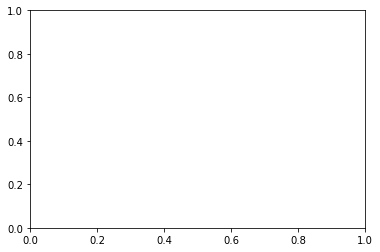

In [58]:
plt.xticks()[1][1].get_label()